In [ ]:
# -*- coding: utf-8 -*-
"""ViT_hand_gesture_recognition_deep_learning_project.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/12NLBt6QISyWRpKwaZMDI_EOG5pMAAfjW
"""


'ViT_hand_gesture_recognition_deep_learning_project.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/12NLBt6QISyWRpKwaZMDI_EOG5pMAAfjW\n'

In [ ]:
# CELL 1: Environment setup
!pip install -q "timm>=0.9.16" "torchinfo>=1.8.0" "seaborn>=0.13" "scikit-learn>=1.5" tqdm opencv-python==4.8.1.78

import os, random, numpy as np, torch

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 17.0 MB/s eta 0:00:00
Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [ ]:
# CELL 2: Kaggle download + unzip + dedupe + canonicalize to /content/leapGestRecog
!pip install -q kaggle
import os, subprocess, glob, shutil
from getpass import getpass

ROOT = "/content"
CANON_PATH = os.path.join(ROOT, "leapGestRecog")
TMP_DIR = os.path.join(ROOT, "_leap_tmp")

def is_dataset_root(p):
    try:
        return os.path.isdir(p) and all(os.path.isdir(os.path.join(p, f"{i:02d}")) for i in range(10))
    except Exception:
        return False

def count_png(p):
    import glob as _g
    return len(_g.glob(f"{p}/**/*.png", recursive=True)) if os.path.isdir(p) else -1

print("== Kaggle one-shot download to /content (dedupe + canonicalize) ==")

deep = os.path.join(ROOT, "leapgestrecog", "leapGestRecog")
upper = os.path.join(ROOT, "LeapGestRecog")
lower = os.path.join(ROOT, "leapGestRecog")
existing_roots = [p for p in [deep, upper, lower] if is_dataset_root(p)]
if is_dataset_root(CANON_PATH):
    DATASET_PATH = CANON_PATH
elif existing_roots:
    best = max(existing_roots, key=count_png)
    if os.path.exists(CANON_PATH):
        shutil.rmtree(CANON_PATH)
    shutil.move(best, CANON_PATH)
    parent = os.path.dirname(best)
    if parent != ROOT and os.path.isdir(parent):
        try: shutil.rmtree(parent)
        except: pass
    DATASET_PATH = CANON_PATH
else:
    if not os.environ.get("KAGGLE_USERNAME") or not os.environ.get("KAGGLE_KEY"):
        os.environ["KAGGLE_USERNAME"] = input("Kaggle username: ").strip()
        os.environ["KAGGLE_KEY"] = getpass("Kaggle API key (hidden): ").strip()

    shutil.rmtree(TMP_DIR, ignore_errors=True)
    os.makedirs(TMP_DIR, exist_ok=True)
    for z in glob.glob(os.path.join(ROOT, "*.zip")):
        try: os.remove(z)
        except: pass

    slug = "gti-upm/leapgestrecog"
    res = subprocess.run(
        ["kaggle", "datasets", "download", "-d", slug, "-p", ROOT, "-q"],
        capture_output=True, text=True
    )
    if res.returncode != 0:
        print("Kaggle download failed.")
        if "403" in res.stderr or "403" in res.stdout or "Unauthorized" in res.stderr:
            print("- Open and Accept the dataset terms, then rerun:")
            print("  https://www.kaggle.com/datasets/gti-upm/leapgestrecog")
        else:
            print("STDOUT:", res.stdout[:400]); print("STDERR:", res.stderr[:400])
        raise SystemExit(1)

    zips = sorted(glob.glob(os.path.join(ROOT, "*.zip")), key=os.path.getmtime, reverse=True)
    if not zips: raise SystemExit("No zip downloaded to /content.")
    outer_zip = zips[0]

    subprocess.run(["unzip", "-q", outer_zip, "-d", TMP_DIR], check=True)

    inner_zips = glob.glob(os.path.join(TMP_DIR, "**", "*.zip"), recursive=True)
    if inner_zips:
        inner_zip = max(inner_zips, key=os.path.getsize)
        subprocess.run(["unzip", "-q", inner_zip, "-d", ROOT], check=True)
    else:
        candidate_dirs = []
        for root, dirs, files in os.walk(TMP_DIR):
            candidate_dirs.append(root)
        dataset_dirs = [p for p in candidate_dirs if is_dataset_root(p)]
        if not dataset_dirs:
            for name in ["leapGestRecog", "LeapGestRecog"]:
                p = os.path.join(TMP_DIR, name)
                if is_dataset_root(p):
                    dataset_dirs = [p]; break
        if not dataset_dirs:
            raise SystemExit("Could not locate dataset folder after unzip.")
        src = max(dataset_dirs, key=count_png)
        if os.path.exists(CANON_PATH):
            shutil.rmtree(CANON_PATH)
        shutil.move(src, CANON_PATH)

    try: os.remove(outer_zip)
    except: pass
    shutil.rmtree(TMP_DIR, ignore_errors=True)
    DATASET_PATH = CANON_PATH

for p in [os.path.join(ROOT, "LeapGestRecog"), os.path.join(ROOT, "leapGestRecog")]:
    if is_dataset_root(p) and p != CANON_PATH:
        if os.path.exists(CANON_PATH): shutil.rmtree(CANON_PATH)
        shutil.move(p, CANON_PATH)

assert is_dataset_root(CANON_PATH), "Final dataset folder not found or malformed."

import glob as _g
imgs = _g.glob(f"{CANON_PATH}/**/*.png", recursive=True)
print(f"Dataset ready at: {CANON_PATH} | images: {len(imgs)}")
print("Subjects:", sorted([d for d in os.listdir(CANON_PATH) if os.path.isdir(os.path.join(CANON_PATH, d))]))
DATASET_PATH = CANON_PATH


== Kaggle one-shot download to /content (dedupe + canonicalize) ==
Kaggle username: OMARAHMED87
Kaggle API key (hidden): ··········
Dataset ready at: /content/leapGestRecog | images: 20000
Subjects: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


Root: /content/leapGestRecog
Train images: 14000 | per-class: {0: 1400, 1: 1400, 2: 1400, 3: 1400, 4: 1400, 5: 1400, 6: 1400, 7: 1400, 8: 1400, 9: 1400}
Val   images: 4000 | per-class: {0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400}
Test  images: 2000 | per-class: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}


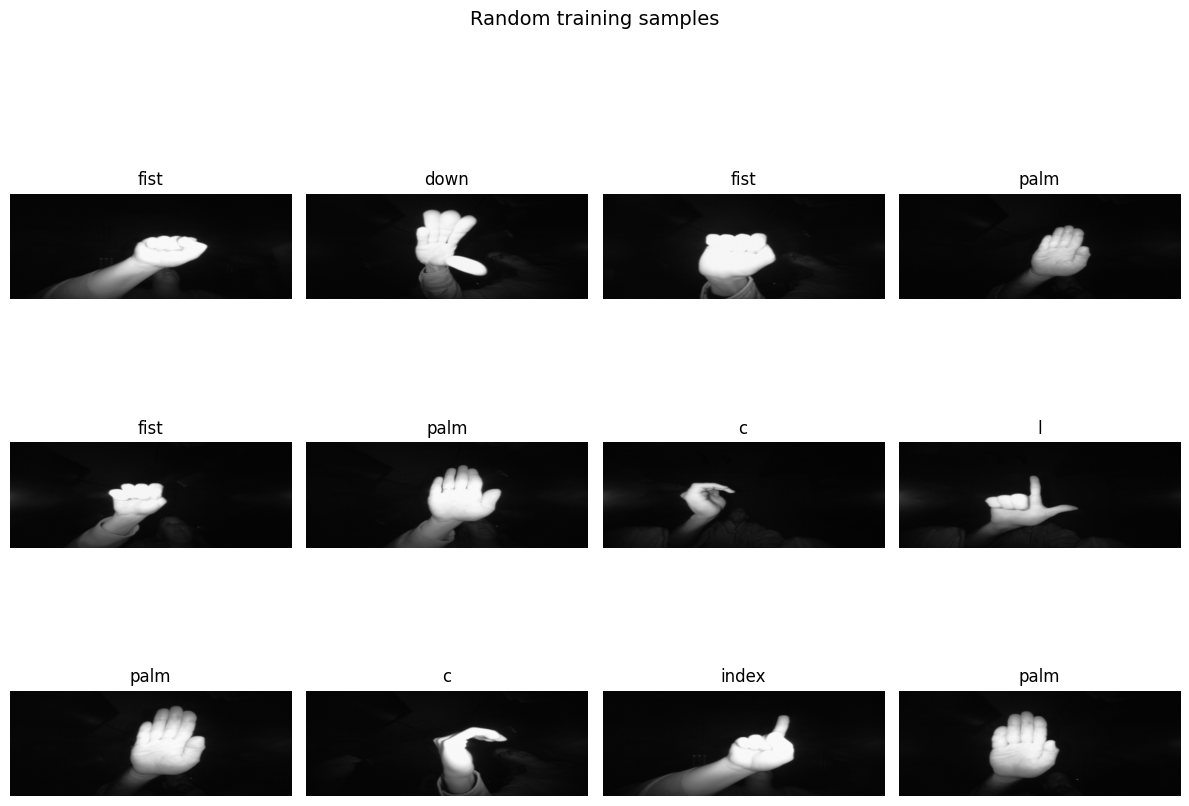

In [ ]:
# CELL 3: Subject-independent split (7 train, 2 val, 1 test) + sanity
import os
from collections import Counter

train_subjects = ['00','01','02','03','04','05','06']
val_subjects   = ['07','08']
test_subjects  = ['09']

gesture_map = {
    '01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4,
    '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9
}
gesture_names = ['palm','l','fist','fist_moved','thumb','index','ok','palm_moved','c','down']
num_classes = len(gesture_names)

def get_paths_and_labels(base_path, selected_subjects):
    paths, labels = [], []
    for subject in selected_subjects:
        subject_path = os.path.join(base_path, subject)
        for gesture_folder, idx in gesture_map.items():
            folder = os.path.join(subject_path, gesture_folder)
            if not os.path.isdir(folder): continue
            for name in os.listdir(folder):
                if name.lower().endswith(".png"):
                    paths.append(os.path.join(folder, name))
                    labels.append(idx)
    return paths, labels

train_paths, train_labels = get_paths_and_labels(DATASET_PATH, train_subjects)
val_paths,   val_labels   = get_paths_and_labels(DATASET_PATH, val_subjects)
test_paths,  test_labels  = get_paths_and_labels(DATASET_PATH, test_subjects)

def sanity(name, labels):
    cnt = dict(sorted(Counter(labels).items()))
    print(f"{name} images: {len(labels)} | per-class:", cnt)

print(f"Root: {DATASET_PATH}")
sanity("Train", train_labels)
sanity("Val  ", val_labels)
sanity("Test ", test_labels)

# CELL 3b (optional): Quick EDA preview
import random, matplotlib.pyplot as plt
from PIL import Image

samples = random.sample(list(zip(train_paths, train_labels)), k=12)
plt.figure(figsize=(12,9))
for i, (p, y) in enumerate(samples, 1):
    plt.subplot(3,4,i); plt.imshow(Image.open(p).convert("RGB")); plt.axis("off"); plt.title(gesture_names[y])
plt.suptitle("Random training samples", y=1.02, fontsize=14); plt.tight_layout(); plt.show()


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

USE_GRAYSCALE = True

base_norm_mean = [0.485, 0.456, 0.406]
base_norm_std  = [0.229, 0.224, 0.225]

prepend_gray = [transforms.Grayscale(num_output_channels=3)] if USE_GRAYSCALE else []

train_transform = transforms.Compose(
    prepend_gray + [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(base_norm_mean, base_norm_std),
    ]
)
val_test_transform = transforms.Compose(
    prepend_gray + [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(base_norm_mean, base_norm_std),
    ]
)

class GestureDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths; self.labels = labels; self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = self.labels[idx]
        img = self.transform(img)
        return img, y

train_dataset = GestureDataset(train_paths, train_labels, train_transform)
val_dataset   = GestureDataset(val_paths,   val_labels,   val_test_transform)
test_dataset  = GestureDataset(test_paths,  test_labels,  val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)
print("DataLoaders ready (simplified aug).")


DataLoaders ready (simplified aug).


In [ ]:
import torch.nn as nn
from torchinfo import summary

class VGG19_Mod(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        def conv_block(in_c, out_c, n):
            layers = []
            for _ in range(n):
                layers += [
                    nn.Conv2d(in_c, out_c, 3, padding=1),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(inplace=True)
                ]
                in_c = out_c
            layers.append(nn.MaxPool2d(2,2))
            return layers

        self.features = nn.Sequential(
            *conv_block(3,   64,2),
            *conv_block(64, 128,2),
            *conv_block(128,256,4),
            *conv_block(256,512,4),
            *conv_block(512,512,4),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = VGG19_Mod(num_classes=num_classes).to(device)
summary(model, (1,3,224,224))


Layer (type:depth-idx)                   Output Shape              Param #
VGG19_Mod                                [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 112, 112]        256
│    └─ReLU: 2-10                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [1, 128, 112, 112]        147,

In [ ]:
import torch.optim as optim

def mixup(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx], lam, idx

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


/tmp/ipython-input-3745212935.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
  def train_one_epoch():
      model.train()
      total, correct, loss_sum = 0,0,0

      for x,y in train_loader:
          x,y = x.to(device), y.to(device)
          optimizer.zero_grad()

          # MixUp ----------------------------------------------------
          x_mixed, y_mixed, lam, idx = mixup(x, y)
          y_a = y
          y_b = y[idx]
          # -----------------------------------------------------------

          with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
              out = model(x_mixed)
              loss = lam * criterion(out, y_a) + (1-lam) * criterion(out, y_b)

          scaler.scale(loss).backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          scaler.step(optimizer)
          scaler.update()

          loss_sum += loss.item() * x.size(0)

      return loss_sum / len(train_dataset)

  def eval_epoch(loader):
      model.eval()
      correct,total,loss_sum = 0,0,0
      with torch.no_grad():
          for x,y in loader:
              x,y = x.to(device), y.to(device)
              with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                  out = model(x)
                  loss = criterion(out, y)
              loss_sum += loss.item()*x.size(0)
              correct += (out.argmax(1)==y).sum().item()
              total += y.size(0)
      return loss_sum/total, 100*correct/total

  EPOCHS=20
  best=0
  for e in range(1,EPOCHS+1):
      tl = train_one_epoch()
      vl,va = eval_epoch(val_loader)
      scheduler.step()
      print(f"[{e:02d}] TrainLoss={tl:.4f} | ValAcc={va:.2f}%")

      if va>best:
          best=va
          torch.save(model.state_dict(),"best_vgg_mixup.pth")
          print("  Saved new best model")


/tmp/ipython-input-3451677596.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-3451677596.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[01] TrainLoss=1.1493 | ValAcc=47.90%
  Saved new best model
[02] TrainLoss=0.8584 | ValAcc=65.90%
  Saved new best model
[03] TrainLoss=0.7602 | ValAcc=67.95%
  Saved new best model
[04] TrainLoss=0.7466 | ValAcc=73.90%
  Saved new best model
[05] TrainLoss=0.7104 | ValAcc=73.83%
[06] TrainLoss=0.6605 | ValAcc=75.20%
  Saved new best model
[07] TrainLoss=0.6491 | ValAcc=76.12%
  Saved new best model
[08] TrainLoss=0.6492 | ValAcc=73.10%
[09] TrainLoss=0.6499 | ValAcc=75.72%
[10] TrainLoss=0.6506 | ValAcc=76.28%
  Saved new best model
[11] TrainLoss=0.6336 | ValAcc=77.40%
  Saved new best model
[12] TrainLoss=0.6211 | ValAcc=75.72%
[13] TrainLoss=0.6267 | ValAcc=76.50%
[14] TrainLoss=0.6147 | ValAcc=76.72%
[15] TrainLoss=0.6074 | ValAcc=76.55%
[16] TrainLoss=0.5986 | ValAcc=76.15%
[17] TrainLoss=0.6229 | ValAcc=76.47%
[18] TrainLoss=0.6145 | ValAcc=77.00%
[19] TrainLoss=0.6036 | ValAcc=77.42%
  Saved new best model
[20] TrainLoss=0.6136 | ValAcc=77.17%


FINAL TEST ACCURACY (held-out subject): 98.650%


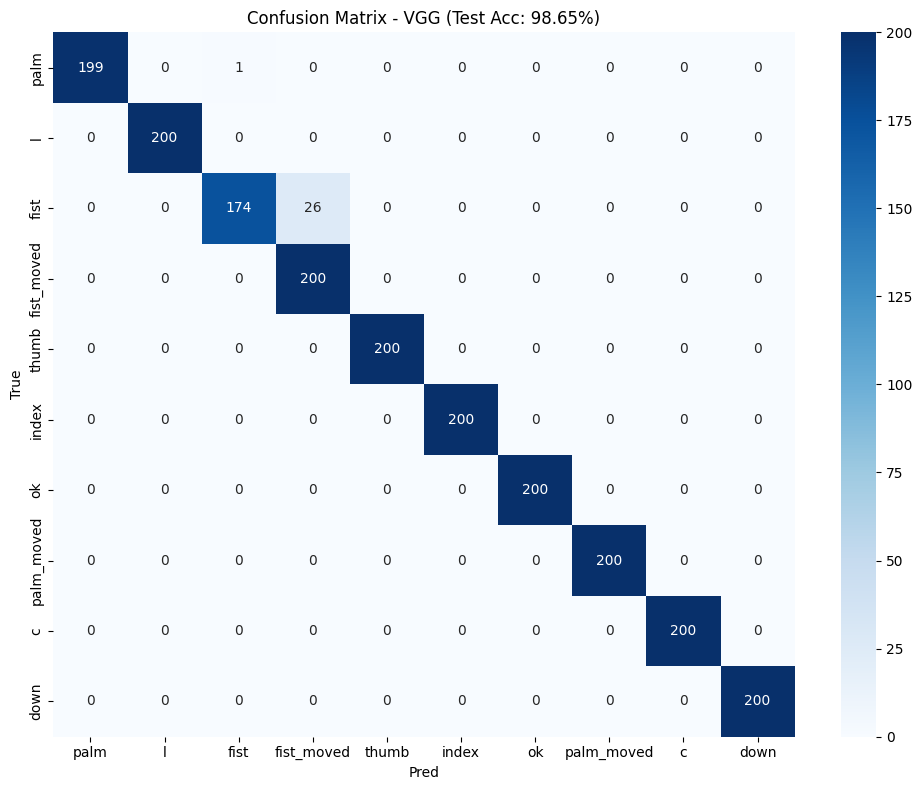

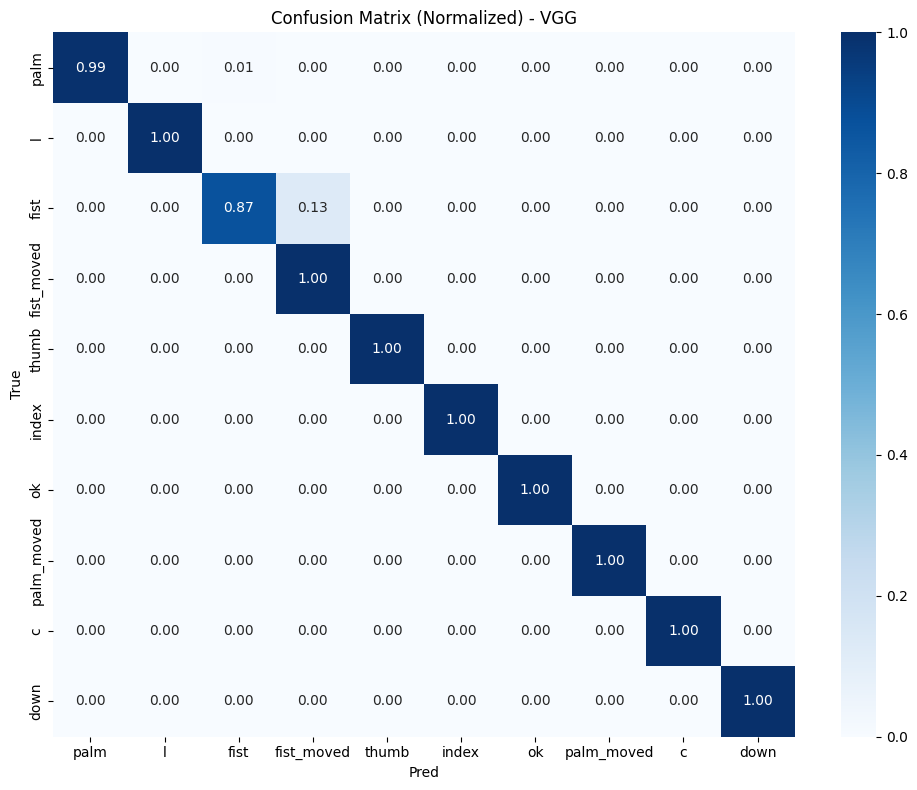

Saved reports in results/


In [ ]:
# CELL 8: Final test evaluation + confusion matrices + reports (AMP new API)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
model.load_state_dict(torch.load("best_vgg_mixup.pth", map_location=device))

model.eval()

all_preds, all_labels, all_probs = [], [], []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
    for inputs, labels in test_loader:
        probs = torch.softmax(model(inputs.to(device, non_blocking=True)), dim=1).cpu().numpy()
        preds = probs.argmax(1)
        all_probs.extend(probs); all_preds.extend(preds); all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
test_acc = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"FINAL TEST ACCURACY (held-out subject): {test_acc:.3f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gesture_names, yticklabels=gesture_names)
plt.title(f'Confusion Matrix - VGG (Test Acc: {test_acc:.2f}%)'); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout(); plt.savefig("results/vgg_confusion_matrix_raw.png", dpi=150); plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('Confusion Matrix (Normalized) - VGG'); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout(); plt.savefig("results/vgg_confusion_matrix_norm.png", dpi=150); plt.show()

rep = classification_report(all_labels, all_preds, target_names=gesture_names, output_dict=True)
pd.DataFrame(rep).transpose().to_csv("results/vgg_classification_report.csv")
pd.DataFrame({"true": all_labels, "pred": all_preds}).to_csv("results/vgg_test_predictions.csv", index=False)
print("Saved reports in results/")


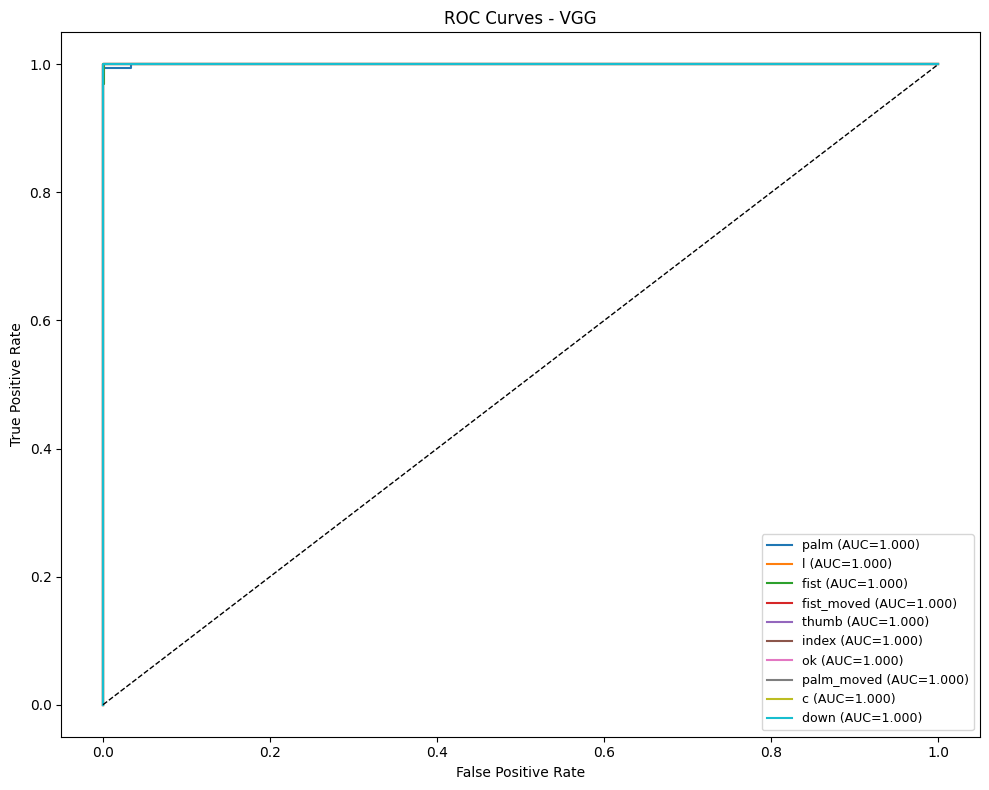

Macro AUC: 1.0000 | Micro AUC: 0.9999


In [ ]:
# CELL 9: ROC/AUC (per-class, micro, macro)
import numpy as np, matplotlib.pyplot as plt, json
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
auc_scores = []
plt.figure(figsize=(10,8))

for i in range(num_classes):
    if y_true_bin[:, i].sum() in (0, len(y_true_bin)):
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    auc = roc_auc_score(y_true_bin[:, i], all_probs[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f'{gesture_names[i]} (AUC={auc:.3f})')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.title('ROC Curves - VGG'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout(); plt.savefig("results/vgg_roc_curves.png", dpi=150); plt.show()

macro_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_true_bin, all_probs, average="micro", multi_class="ovr")
print(f"Macro AUC: {macro_auc:.4f} | Micro AUC: {micro_auc:.4f}")
with open("results/vit_auc.json","w") as f:
    json.dump({"macro_auc": float(macro_auc), "micro_auc": float(micro_auc)}, f, indent=2)


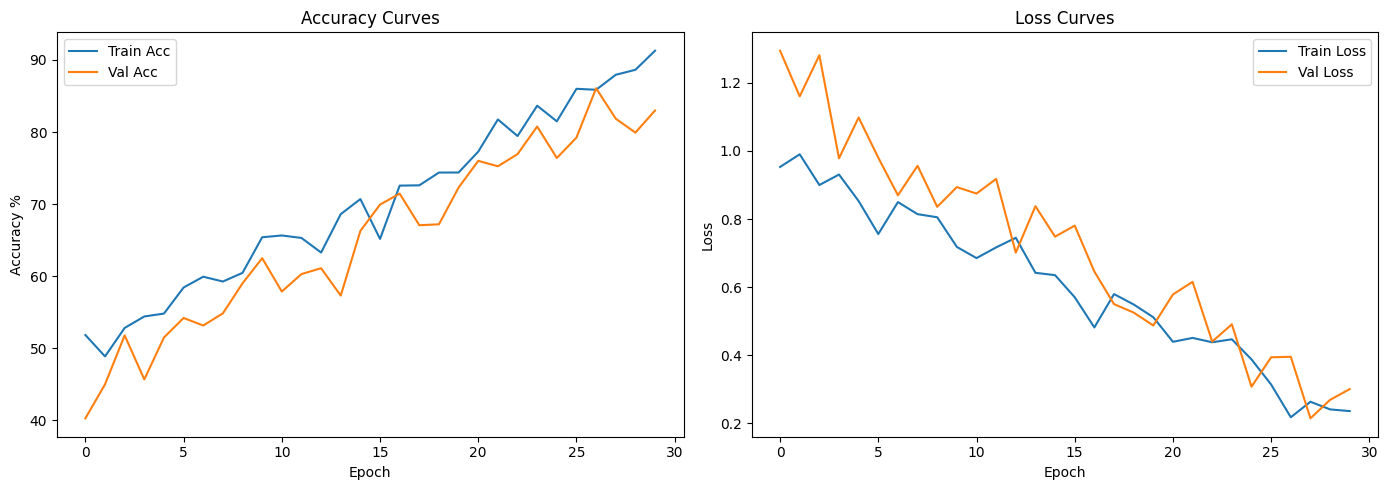

In [ ]:
# CELL 10: Training curves
import matplotlib.pyplot as plt, pandas as pd

hist_df = pd.read_csv("results/vgg_history.csv")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist_df['train_acc'], label='Train Acc'); plt.plot(hist_df['val_acc'], label='Val Acc')
plt.title('Accuracy Curves'); plt.xlabel('Epoch'); plt.ylabel('Accuracy %'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_df['train_loss'], label='Train Loss'); plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss Curves'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout(); plt.savefig("results/vgg_training_curves.png", dpi=150); plt.show()


Upload one or more PNG/JPG gesture images... (inference uses VGG)


Saving frame_04_04_0003.png to frame_04_04_0003.png
frame_04_04_0003.png → fist_moved (93.85%)


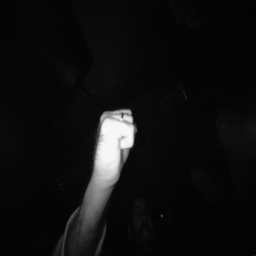

Train: {'04', '02', '01', '06', '03', '05', '00'} Val: {'08', '07'} Test: {'09'}
Subject-independent split: OK ✅
Throughput: 166.9 img/s | 5.99 ms/img


In [ ]:
# CELL 11: Upload & Predict demo (Colab-friendly)
from google.colab import files
from PIL import Image
import io, numpy as np, torch

def predict_image(img: Image.Image):
    model.eval()
    x = val_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
        probs = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    pred = int(np.argmax(probs))
    return gesture_names[pred], probs[pred]

print("Upload one or more PNG/JPG gesture images... (inference uses VGG)")
uploaded = files.upload()
for name, data in uploaded.items():
    img = Image.open(io.BytesIO(data)).convert("RGB")
    pred, conf = predict_image(img)
    print(f"{name} → {pred} ({conf*100:.2f}%)")
    display(img.resize((256,256)))

# OPTIONAL: split sanity + inference speed
import re, time
def get_subject_ids(paths):
    return set([re.search(r'/(\d{2})/', p).group(1) for p in paths])

train_subj = get_subject_ids(train_paths); val_subj = get_subject_ids(val_paths); test_subj = get_subject_ids(test_paths)
print("Train:", train_subj, "Val:", val_subj, "Test:", test_subj)
assert train_subj.isdisjoint(val_subj) and train_subj.isdisjoint(test_subj) and val_subj.isdisjoint(test_subj)
print("Subject-independent split: OK ✅")

# Inference throughput
model.eval(); start = time.time()
with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
    for x,_ in test_loader: _ = model(x.to(device, non_blocking=True))
elapsed = time.time() - start
print(f"Throughput: {len(test_dataset)/elapsed:.1f} img/s | {elapsed/len(test_dataset)*1000:.2f} ms/img")